In [ ]:
!pip install -q chromadb praw openai load-dotenv langchain langchain-openai langchain-text-splitters langgraph

In [2]:
import json
import os
import time
from typing import List, Dict, TypedDict

import chromadb
import praw
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from openai import OpenAI

# Marketing Research Agent

## Knowledge base generation pipeline

In [3]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
CLIENT_ID = os.getenv('REDDIT_CLIENT_ID')
CLIENT_SECRET = os.getenv('REDDIT_CLIENT_SECRET')
USER_AGENT = os.getenv('REDDIT_USER_AGENT')

GENERATE_KNOWLEDGE = False

In [4]:
client = OpenAI()
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent=USER_AGENT)

In [5]:
def get_relevant_topics(query: str) -> list:
    """
    Use OpenAI to generate relevant search phrases for a query
    """
    prompt = f"""
        You are a Reddit search expert who understands how Redditors discuss and search for topics.
        Given the query "{query}", generate 5 search phrases that will find the most relevant subreddits.

        Consider:
        - How Redditors naturally phrase their questions/discussions
        - Common abbreviations and terminology used on Reddit
        - Related tools, technologies, or concepts frequently discussed
        - Industry-specific subreddit naming patterns
        - Problem-focused search terms (as many discussions are about solving problems)

        For example, if query is "project management software":
        - projectmanagement (direct community)
        - asana vs trello (tool comparison commonly discussed)
        - agile tools (methodology + tools)
        - jira alternatives (tool alternative discussions)
        - remote team management (broader problem space)
        Return exactly 5 search phrases, one per line.
        Focus on phrases that would lead to active, relevant subreddit communities.
        Do not include any bullets, numbers, or prefixes.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{
                "role": "user",
                "content": prompt
            }],
            temperature=0.5,
            max_tokens=256
        )
        
        # Extract and clean phrases
        search_phrases = [
            phrase.strip()
            for phrase in response.choices[0].message.content.split('\n')
            if phrase.strip() and not phrase.startswith(('-', '*', '•', '1', '2', '3', '4', '5'))
        ]
        
        print(f"Generated search phrases: {search_phrases}")
        return search_phrases
    except Exception as e:
        print(f"Error generating topics: {e}")
        return [query]


In [6]:
def search_subreddits(search_terms, limit=50):
    """
    Search for subreddits matching multiple search terms.
    
    Args:
        search_terms (list): List of search queries to use
        limit (int): Maximum number of subreddits to return per search term
    
    Returns:
        list: List of unique subreddit names found across all search terms
    """
    print(f"Searching for subreddits matching {len(search_terms)} search terms...")
    subreddits = set()  # Using a set to avoid duplicates
    
    try:
        for term in search_terms:
            print(f"Searching with term: '{term}'...")
            term_subreddits = []  
            for subreddit in reddit.subreddits.search(term, limit=limit):
                subreddits.add(subreddit.display_name)
                term_subreddits.append(subreddit.display_name)
            print(f"Found with '{term}': {term_subreddits}")
    except Exception as e:
        print(f"Error during subreddit search: {e}")
    
    return list(subreddits)  # Convert set back to list for consistency

In [7]:
def get_subreddit_info(subreddit_name):
    """
    Retrieve information about a subreddit.
    """
    try:
        subreddit = reddit.subreddit(subreddit_name)
        return {
            'name': subreddit.display_name,
            'title': subreddit.title,
            'subscribers': subreddit.subscribers,
            'public_description': subreddit.public_description
        }
    except Exception as e:
        print(f"Error retrieving info for r/{subreddit_name}: {e}")
        return None

In [8]:
def get_subreddit_posts(subreddit_name: str, max_posts: int, max_comments: int = None):
    """
    Fetch all posts and comments from a subreddit, and extract problem-related sentences.
    """
    subreddit = reddit.subreddit(subreddit_name)
    posts_data = []

    print(f"Fetching posts from r/{subreddit_name}...")

    try:
        for post in subreddit.new(limit=max_posts):
            post_info = {
                'id': post.id,
                'title': post.title,
                'author': str(post.author),
                'score': post.score,
                'upvotes': post.ups,
                'downvotes': post.downs,
                'num_comments': post.num_comments,
                'created_utc': post.created_utc,
                'url': post.url,
                'permalink': post.permalink,
                'selftext': post.selftext,
                'comments': []
            }

            post.comments.replace_more(limit=max_comments)
            print(f"Fetching comments for post ID {post.id}...")
            for comment in post.comments.list():
                comment_info = {
                    'id': comment.id,
                    'author': str(comment.author),
                    'body': comment.body,
                    'score': comment.score,
                    'upvotes': comment.ups,
                    'downvotes': comment.downs,
                    'created_utc': comment.created_utc,
                    'parent_id': comment.parent_id,
                    'link_id': comment.link_id,
                    'permalink': comment.permalink
                }

                post_info['comments'].append(comment_info)

            posts_data.append(post_info)
            time.sleep(0.5)

    except Exception as e:
        print(f"Error fetching posts from r/{subreddit_name}: {e}")

    return posts_data

In [9]:
def process_and_store_in_chroma(posts_data: List[Dict], collection_name: str):
    chroma_client = chromadb.PersistentClient(path="data/chroma_db")
    embeddings_client = OpenAIEmbeddings(
        model="text-embedding-3-small",
        openai_api_key=OPENAI_API_KEY
    )

    collection = chroma_client.get_or_create_collection(name=collection_name)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50
    )

    documents = []
    metadatas = []
    ids = []
    doc_id = 0

    print(f"Processing posts and comments for {collection_name}...")

    for post in posts_data:
        if post["selftext"]:
            chunks = text_splitter.split_text(post["selftext"]) if len(post["selftext"]) > 500 else [post["selftext"]]

            chunk_embeddings = embeddings_client.embed_documents(chunks)

            for chunk, embedding in zip(chunks, chunk_embeddings):
                documents.append(chunk)
                metadatas.append({
                    "id": post["id"],
                    "type": "post",
                    "title": post["title"],
                    "author": post["author"],
                    "url": post["url"],
                    "created_utc": str(post["created_utc"])
                })
                ids.append(f"doc_{doc_id}")
                doc_id += 1

        for comment in post.get("comments", []):
            if comment["body"]:
                chunks = text_splitter.split_text(comment["body"]) if len(comment["body"]) > 500 else [comment["body"]]

                chunk_embeddings = embeddings_client.embed_documents(chunks)

                for chunk, embedding in zip(chunks, chunk_embeddings):
                    documents.append(chunk)
                    metadatas.append({
                        "id": comment["id"],
                        "type": "comment",
                        "post_id": post["id"],
                        "post_title": post["title"],
                        "author": comment["author"],
                        "parent_id": comment["parent_id"],
                        "url": comment["url"],
                        "created_utc": str(comment["created_utc"])
                    })
                    ids.append(f"doc_{doc_id}")
                    doc_id += 1

        if len(documents) >= 500:
            embeddings = embeddings_client.embed_documents(documents)
            collection.add(
                documents=documents,
                embeddings=embeddings,
                metadatas=metadatas,
                ids=ids
            )
            print(f"Added batch of {len(documents)} documents to Chroma")
            documents = []
            metadatas = []
            ids = []

    # Add any remaining documents
    if documents:
        embeddings = embeddings_client.embed_documents(documents)
        collection.add(
            documents=documents,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids
        )
        print(f"Added final batch of {len(documents)} documents to Chroma")

    return collection.count()

In [10]:
def generate_knowledge_base(user_query: str, max_subreddits: int, min_subscribers: int, max_posts: int, max_comments: int = None):    
    search_terms = get_relevant_topics(query=user_query)
    found_subreddits = search_subreddits(search_terms=search_terms, limit=max_subreddits)
    
    if not found_subreddits:
        print("No subreddits with enough subscribers found with the given query.")
        return
    
    print("\nRetrieving subreddit information...")
    subreddit_infos = []
    for subreddit_name in found_subreddits:
        info = get_subreddit_info(subreddit_name)
        if info:
            subreddit_infos.append(info)
        time.sleep(1)
        
    for info in subreddit_infos:
        if info['subscribers'] > min_subscribers:
            subreddit_name = info['name']
            print(f"\nProcessing r/{subreddit_name}...")
            
            posts = get_subreddit_posts(subreddit_name, max_posts, max_comments)
    
            try:
                collection_name = f"reddit_{subreddit_name.lower()}"
                doc_count = process_and_store_in_chroma(posts, collection_name)
                print(f"Processed and stored {doc_count} documents in Chroma collection '{collection_name}'")
            except Exception as e:
                print(f"Error processing and storing data in Chroma: {e}")

In [11]:
if GENERATE_KNOWLEDGE:
    query = input("Enter the search query for subreddits: ")
    max_subreddits = int(input("Enter the number of subreddits to find: "))
    generate_knowledge_base(user_query=query, max_subreddits=max_subreddits, min_subscribers=100000, max_posts=100)

## Agent workflow

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

from langgraph.graph import END, START, StateGraph

In [13]:
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [14]:
def query_chroma(query_text: str, collection_name: str, n_results: int = 5):
    """
    Query the Chroma database for similar content.
    """
    chroma_client = chromadb.PersistentClient(path="data/chroma_db")
    embeddings_client = OpenAIEmbeddings(
        model="text-embedding-3-small",
        openai_api_key=OPENAI_API_KEY
    )

    collection = chroma_client.get_collection(name=collection_name)
    query_embedding = embeddings_client.embed_query(query_text)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

In [15]:
def query_and_format_results(query_text: str, collection_name: str, n_results: int = 5) -> Dict[dict, list]:
    """
    Query Chroma and return formatted results with all related information.

    Args:
        query_text (str): The search query
        collection_name (str): Name of the Chroma collection to search
        n_results (int): Number of results to return

    Returns:
        dict: Formatted results with query info and matched documents
    """
    try:
        # Get raw results from Chroma
        results = query_chroma(query_text, collection_name, n_results)

        # Format the results
        formatted_results = {
            "query_info": {
                "search_query": query_text,
                "collection": collection_name,
                "total_results": len(results['ids'][0])
            },
            "matches": []
        }

        # Process each result
        for i in range(len(results['ids'][0])):
            match = {
                "content": results['documents'][0][i],
                "metadata": results['metadatas'][0][i],
                "distance": results['distances'][0][i] if 'distances' in results else None
            }
            formatted_results["matches"].append(match)

        return formatted_results

    except Exception as e:
        print(f"Error querying database: {e}")
        return None


In [16]:
def augment_query(query_text: str, query_file_path: str = 'augment.json'):
    """Augment query using json"""
    try:
        with open(query_file_path, 'r') as f:
            rules = json.load(f)
            return [f"{rule.get('prefix', '')} {query_text} {rule.get('suffix', '')}".strip() 
                    for rule in rules.get('searches', [])]
    except:
        return [query_text]

In [17]:
def retrieve(state):
    query = state["query"]
    # TODO: Determine best collection
    # collection_name = state["collection"]
    collection_name = "reddit_digitalmarketing"

    augmented_queries = augment_query(query)
    
    for augmented_query in augmented_queries:
        print(f"=== Search augmented query: {augmented_query} ===")
        results = query_and_format_results(augmented_query, collection_name)
        
    return {"results": results, "query": query}

In [18]:
def generate(state):
    results = state["results"]
    query = state["query"]
    
    context_parts = []
    for match in results['matches']:
        metadata = match['metadata']
        source_info = f"Source: {metadata['type'].capitalize()}"
        if metadata['type'] == 'post':
            source_info += f" - Title: {metadata['title']}"
        
        context_parts.append(f"{source_info}\nContent: {match['content']}\n")
        
    context = "\n".join(context_parts)

    with open('generator_prompt.txt', 'r') as f:
        sys_prompt = f.read()
    
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=sys_prompt),
        AIMessage(content=f"**Context:**\n{context}\n\n"),
        HumanMessage(content=f"**Question:** {query}")
    ])
    
    generator = prompt | llm
    response = generator.invoke({})
    
    return {"results": results, "query": query, "generation": response.content}  

In [19]:
class AgentState(TypedDict):
    query : str
    generation: str
    results : Dict[dict, list]

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node(retrieve, "retrieve")
workflow.add_node(generate, "generate")

workflow.add_edge(start_key=START, end_key="retrieve")
workflow.add_edge(start_key="retrieve", end_key="generate")
workflow.add_edge(start_key="generate", end_key=END)

graph = workflow.compile()

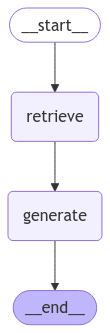

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
inputs = {"query": "What are the best tools for lead generation?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
        if 'generation' in value:
            print(value['generation'])
        

=== Search augmented query: What are the best tools for lead generation? ===
Finished running: retrieve:
Finished running: generate:
**1. Key Findings:**

- There is a high demand for effective and affordable B2B lead generation and management tools.
- Users are overwhelmed by the number of options available and are seeking recommendations based on personal experiences.
- Tools mentioned include Hubspot, ActiveCampaign, Mailchimp, Monday CRM, LinkedIn’s SalesFlow, Warmly, and ZoomInfo.
- Some users have tried PPC and SEO strategies but have struggled with lead generation and conversion.
- There is a suggestion to hire an SDR (Sales Development Representative) for outbound efforts.

**2. Market Implications:**

- There is a market opportunity for affordable, user-friendly B2B lead generation and management tools.
- The market is saturated with options, creating confusion and decision paralysis among potential users.
- There is a potential gap in the market for tools or services that eff